# Chargement et Prétraitement du Dataset

### 🧩 Charger les images du dataset et vérifier leurs extensions

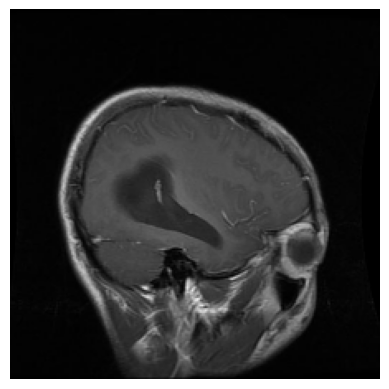

In [3]:
import os
import random
import cv2
import numpy as np
from pathlib import Path

folder = r"B:\Deep Learning\BrainScan\data\images IRM"

extensions = ('.jpg', '.jpeg', '.png','.bmp')
images = []
labels = []

for class_name in os.listdir(folder):
    class_folder = os.path.join(folder,class_name)
    if os.path.isdir(class_folder):
        for file in os.listdir(class_folder):
            if file.lower().endswith(extensions):
                try:
                    file_name = os.path.join(class_folder, file)
                    img = cv2.imread(file_name)
                    if img is None:
                        raise Exception("Image corrompue ou non lisible")
                    img = cv2.resize(img,(224,224))
                    images.append(img)
                    labels.append(class_name)

                except Exception as e:
                    os.remove(file_name)
                    continue

                    

paired = list(zip(images, labels))
random.shuffle(paired)

image_shuffled = []
labels_shuffled = []

for pair in paired:
    image_shuffled.append(pair[0])
    labels_shuffled.append(pair[1])


images_array = np.array(image_shuffled)
labels_array = np.array(labels_shuffled)

import matplotlib.pyplot as plt

if len(images_array) == 0:
    print("Aucune image valide trouvée.")
else:
    plt.imshow(images_array[0])
    plt.axis('off')
    plt.show()

### Histogramme du nombre d’images par catégorie

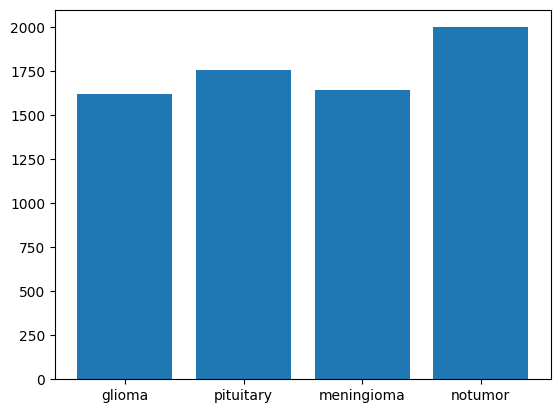

In [4]:
from collections import Counter

class_counts = Counter(labels_array)


classes  = list(class_counts.keys())
counts = list(class_counts.values())

plt.bar(classes,counts)
plt.show()


### Visualisation des échantillons du dataset par classe

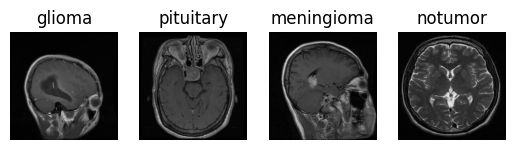

In [5]:
echantillon_images = {}

for i in range(len(images_array)):
    lable = labels_array[i]
    if lable not in echantillon_images:
        echantillon_images[lable] = images_array[i]
i=0
for label in echantillon_images:
    plt.subplot(1,4,i+1)
    plt.imshow(echantillon_images[label])
    plt.title(label)
    plt.axis('off')
    i+=1
    
plt.show()      

### Détection et correction du déséquilibre des classes

In [6]:
class_counts = Counter(labels_array)
    
for label,count in class_counts.items():
    print(f"{label} : {count}")



# Pourquoi utiliser l'undersampling ici ?
# La classe "notumor" est légèrement plus grande que les autres classes.
# Pour équilibrer le dataset avant l'entraînement du CNN et éviter que
# le modèle ne favorise cette classe majoritaire, 
# on peut réduire légèrement sa taille (undersampling) afin que 
# toutes les classes aient le même nombre d'exemples.

glioma : 1621
pituitary : 1757
meningioma : 1645
notumor : 2000


### Transformation des étiquettes textuelles en entiers

In [7]:
from sklearn.preprocessing import LabelEncoder
lables = ["notumor", "glioma", "meningioma", "pituitary"]
encoder = LabelEncoder()
labels_array = encoder.fit_transform(labels_array)

print(labels_array)



[0 3 1 ... 1 2 0]


### Augmentation et rééquilibrage des données d’images

In [8]:
import numpy as np
import pandas as pd
from collections import Counter,defaultdict
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

images_par_classe = defaultdict(list)
for i, label in enumerate(labels_array):
    images_par_classe[label].append(images_array[i])

max_count = 2000

image_balanced = []
labels_balanced = []

for label, imgs in images_par_classe.items():
    while len(imgs) < max_count:
        img = random.choice(imgs)
        img_aug = datagen.random_transform(img)
        imgs.append(img_aug)
    
    image_balanced.extend(imgs)
    labels_balanced.extend([label]*max_count)

for i in range(len(image_balanced)):
    image_balanced[i] = image_balanced[i] / 255.0


print(Counter(labels_balanced))



Counter({np.int64(0): 2000, np.int64(3): 2000, np.int64(1): 2000, np.int64(2): 2000})


### Division des données en ensembles d’entraînement et de test 

In [10]:
from sklearn.model_selection import train_test_split

x = image_balanced
y = labels_balanced

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

np.save('../data/processed/x_train.npy', x_train)
np.save('../data/processed/x_test.npy', x_test)
np.save('../data/processed/y_train.npy', y_train)
np.save('../data/processed/y_test.npy', y_test)

# from imblearn.under_sampling  import RandomUnderSampler

# res = RandomUnderSampler(random_state=42)
# x_res,y_res = res.fit_resample(x,y)

# image_balenced = x_res.reshape(-1, 224, 224, 3)
# labels_balanced = y_res


# class_counts = Counter(y_res)
# for label,count in class_counts.items():
#     print(f"{label} : {count}")

# image_balenced = image_balenced/255
# print(image_balenced.min(), image_balenced.max())


    